In [2]:
from scipy.stats import pearsonr
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform


In [3]:
networks_matidx = [69, 53, 98, 99, 45, 21, 56, 3, 9, 2, 11, 27, 54, 66, 80, 72, 16, 5, 62, 15, 12, 93, 20, 8, 77, 68, 33, 43, 70, 61, 55, 63, 79, 84, 96, 88, 48, 81, 37, 67, 38, 83, 32, 40, 23, 71, 17, 51, 94, 13, 18, 4, 7]
print("Network indices (Matlab indices) \n", networks_matidx)
networks_pyidx = [c-1 for c in networks_matidx]
print("Network indices (pyhotn indices) \n", networks_pyidx)

Network indices (Matlab indices) 
 [69, 53, 98, 99, 45, 21, 56, 3, 9, 2, 11, 27, 54, 66, 80, 72, 16, 5, 62, 15, 12, 93, 20, 8, 77, 68, 33, 43, 70, 61, 55, 63, 79, 84, 96, 88, 48, 81, 37, 67, 38, 83, 32, 40, 23, 71, 17, 51, 94, 13, 18, 4, 7]
Network indices (pyhotn indices) 
 [68, 52, 97, 98, 44, 20, 55, 2, 8, 1, 10, 26, 53, 65, 79, 71, 15, 4, 61, 14, 11, 92, 19, 7, 76, 67, 32, 42, 69, 60, 54, 62, 78, 83, 95, 87, 47, 80, 36, 66, 37, 82, 31, 39, 22, 70, 16, 50, 93, 12, 17, 3, 6]


In [4]:
repeat_num, split_num = 0, 0
tr00 = pickle.load(open('/data/users1/reihaneh/projects/alzheimer_schizophrenia/TC/data/splits/train_r0s0.pkl',"rb"))
tr00.head()

,Diagnosis,Sex,Age,Site,fc_dir,Label,SubID,ICAid
0,MCI,F,95.9,003,/data/qneuromark/Data/ADNI/Updated/fMRI/Result...,1,003_S_1074,NaN
1,MCI,F,89.1,003,/data/qneuromark/Data/ADNI/Updated/fMRI/Result...,1,003_S_1122,NaN
2,MCI,M,81.0,003,/data/qneuromark/Data/ADNI/Updated/fMRI/Result...,1,003_S_6258,NaN
3,AD,M,55.3,003,/data/qneuromark/Data/ADNI/Updated/fMRI/Result...,1,003_S_6264,NaN
4,MCI,M,70.7,003,/data/qneuromark/Data/ADNI/Updated/fMRI/Result...,1,003_S_6268,NaN


In [5]:
demo = tr00

ad_cnt = demo['Label'].value_counts()[1]
sz_cnt = demo['Label'].value_counts()[0]
ad_cnt, sz_cnt

(103, 100)

In [6]:
demo_AD = demo.loc[demo.Label==1]
demo_SZ = demo.loc[demo.Label==0]


In [7]:
def vis_FNC(
    FNC, ax, ax_title="", ax_title_fontsize=14, domnet_labeling=False,
    vmin=None, vmax=None,
    cmap='jet', cbar_kws=None, cbar_ylabel=None, colorbar_ticklabels=None, colorbar_ticks=None,
):
    """
    Visualizes an FNC matrix with functional domain labels
    Parameters
    ----------
    - FNC (ndarray): A 2D NumPy array (with shape=(53, 53)) containing the functional network connectivities.
    - ax (axes.Axes)
    """
    xax_labels = ['','','SC','','',]+['AU',]+['',]*5+['SM',]+['',]*8+['VI',]+['',]*12+['CC',]+['',]*11+['DM',]+['',]*4+['CB',]+['',]*2 
    xax_fontsize = 12
    if domnet_labeling:
        yax_labels, _, _, net_to_dom, _= get_reference_comp()
        yax_labels = [f'{net_to_dom[y]} {y}' for y in yax_labels]
        yax_fontsize = 7
    else:
        yax_labels = xax_labels
        yax_fontsize = xax_fontsize
    ax.set_title(ax_title, fontsize=ax_title_fontsize)
    heatmap = sns.heatmap(
        FNC, ax=ax, cmap=matplotlib.cm.get_cmap(cmap) if cmap==None else cmap,
        cbar_kws=cbar_kws, vmin=vmin, vmax=vmax,
        yticklabels=yax_labels, xticklabels=xax_labels,
    )
    heatmap.hlines([0,5,7,16,25,42,49,53], *ax.get_xlim(), colors='k')
    heatmap.vlines([0,5,7,16,25,42,49,53], *ax.get_ylim(), colors='k')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=yax_fontsize)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, fontsize=xax_fontsize)
    # Set custom ticks and ticklabels for color bar
    if colorbar_ticklabels!=None:
        colorbar = heatmap.collections[0].colorbar
        colorbar.set_ticks(colorbar_ticks)
        colorbar.set_ticklabels(colorbar_ticklabels)
                      

In [8]:
import numpy as np
from scipy.stats import pearsonr

def compute_dFNC(tc: np.ndarray, networks: list, Fisherz_transformed: bool = False):
    """ 
    Calculates dynamic FNC
    Parameters
    ----------
    - tc: ICA-estimated timecourse with shape=(num of networks, timecourse length)
    - window_size: size of the sliding window for dFNC calculation
    - Fisherz_transformed: The Fisher transform equals the inverse hyperbolic tangen/arctanh
    Returns
    -------
    - dFNC: dynamic FNC
    """
    
    # Splitting the time course into 5 windows of length 31 each
    window_size = 31
    num_windows = int(157 // window_size)
  
    num_nets = len(networks)
    dFNC_windows = np.zeros((num_windows, num_nets, num_nets))
    p_val_windows = np.zeros((num_windows, num_nets, num_nets))
    for ind1, comp1 in enumerate(networks):
        for ind2, comp2 in enumerate(networks):
            if ind1 == ind2:
                dFNC_windows[:, ind1, ind2] = np.nan
                p_val_windows[:, ind1, ind2] = np.nan
            else:
                for window in range(num_windows):
                    window_start = window * window_size
                    window_end = (window + 1) * window_size
                    FNC, p = pearsonr(tc[comp1, window_start:window_end], tc[comp2, window_start:window_end])
                    dFNC_windows[window, ind1, ind2] = FNC
                    p_val_windows[window, ind1, ind2] = p
                if Fisherz_transformed:
                    dFNC_windows[:, ind1, ind2] = np.arctanh(dFNC_windows[:, ind1, ind2])

    return dFNC_windows

def save_samplewise_dfnc(tc, networks_pyidx, n):
    num_samples = n
    dfnc_arr = np.zeros((num_samples, int(157//window_size), len(networks_matidx), len(networks_matidx) ))
    for i in range(num_samples):
        dfnc = compute_dFNC(tc[i], networks_pyidx)
        dfnc_arr[i] = dfnc
    return dfnc_arr


In [9]:

ad_tc = np.random.rand(ad_cnt, 100, 157)
sz_tc = np.random.rand(sz_cnt, 100, 157)
window_size = 31
Fisherz_transformed = False

ad_dfnc = np.zeros((ad_cnt, (157//window_size), len(networks_matidx), len(networks_matidx) ))
sz_dfnc = np.zeros((sz_cnt, (157//window_size), len(networks_matidx), len(networks_matidx) ))
ad_dfnc=[]
i=0
for subj_id, row in demo_AD.iterrows():
    ad_tc[i] = np.load(f'/data/users1/reihaneh/projects/alzheimer_schizophrenia/TC/data/original/{row.SubID}.npy')
    i=i+1
i=0        
for subj_id, row in demo_SZ.iterrows():
    sz_tc[i] = np.load(f'/data/users1/reihaneh/projects/alzheimer_schizophrenia/TC/data/original/{row.SubID}.npy')
    i=i+1

'''i=0
for i in range (ad_cnt):
    print(i)'''
ad_dfnc = save_samplewise_dfnc(ad_tc, networks_pyidx, ad_cnt)
    

sz_dfnc = save_samplewise_dfnc(sz_tc, networks_pyidx, sz_cnt)


In [10]:
sz_dfnc.shape

(100, 5, 53, 53)

In [11]:
ad_dfnc.shape

(103, 5, 53, 53)

In [12]:
np.save("samplewise_ad_dfnc", ad_dfnc)
np.save("samplewise_sz_dfnc", sz_dfnc)

In [21]:
sz_dfnc

array([[[[            nan, -1.76154503e-01,  3.03733604e-01, ...,
          -2.66271654e-01, -4.47664245e-01, -3.38255463e-01],
         [-1.76154503e-01,             nan,  2.22254443e-01, ...,
           2.69726620e-01,  2.55136790e-01,  1.05719654e-01],
         [ 3.03733604e-01,  2.22254443e-01,             nan, ...,
          -4.73225184e-01,  6.01863170e-02, -2.53927220e-01],
         ...,
         [-2.66271654e-01,  2.69726620e-01, -4.73225184e-01, ...,
                      nan,  2.95489869e-01,  6.88382160e-01],
         [-4.47664245e-01,  2.55136790e-01,  6.01863170e-02, ...,
           2.95489869e-01,             nan,  7.95855733e-01],
         [-3.38255463e-01,  1.05719654e-01, -2.53927220e-01, ...,
           6.88382160e-01,  7.95855733e-01,             nan]],

        [[            nan, -2.84904533e-01,  5.61327973e-01, ...,
          -4.97582907e-01, -6.70376397e-01, -6.50456863e-01],
         [-2.84904533e-01,             nan,  2.44556755e-01, ...,
           2.09228576e

In [14]:
sz_dfnc.shape

(100, 5, 53, 53)

In [42]:
tot_dfnc = np.vstack((ad_dfnc, sz_dfnc))

In [43]:
tot_dfnc.shape

(203, 5, 53, 53)

In [44]:
if np.any(ad_dfnc < 0):
    print("The matrix contains negative values.")
else:
        print("The matrix contains +ve values.")


The matrix contains negative values.


In [45]:
        
if np.any(sz_dfnc < 0):
    print("The matrix contains negative values.")
else:
        print("The matrix contains +ve values.")


The matrix contains negative values.


In [46]:

if np.any(tot_dfnc < 0):
    print("The matrix contains negative values.")
else:
        print("The matrix contains +ve values.")

The matrix contains negative values.


In [123]:
len# Create a list of lower triangular matrices
lower_triangles_list = []
for i in range(tot_dfnc.shape[0]):
    for j in range(tot_dfnc.shape[1]):
        corr_matrix = tot_dfnc[i,j,:,:]
        lower_triangle = np.tril(corr_matrix, k=-1)
        lower_triangles_list.append(lower_triangle)

# Flatten the matrices and stack them into a 2D array
lower_triangles = np.stack([lt.ravel() for lt in lower_triangles_list])

# Apply KMeans clustering to the concatenated data
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(lower_triangles)

# Get the cluster labels and centroids
labels_l = kmeans.labels_
np.save('lt_labels_nonoverlapping.npy', labels_l)
centroids_l = kmeans.cluster_centers_
np.save('l_non_over_centroids.npy', centroids_l)

In [122]:
len(labels_l)

1015

In [124]:
tot_dfnc.shape, labels_l.shape

((203, 5, 53, 53), (1015,))

In [126]:
# Calculate cluster averages of the dfns stored in tot_dfnc
cluster_averages = []

for i in range(kmeans.n_clusters):
    # Find indices of dfns in this cluster
    indices = np.where(labels_l == i)[0]
    
    # Calculate average of the corresponding dfns
    cluster_sum = np.zeros((53, 53))
    for index in indices:
        cluster_sum += tot_dfnc[index // 5, index % 5, :, :]
    cluster_average = cluster_sum / len(indices)
    
    cluster_averages.append(cluster_average)


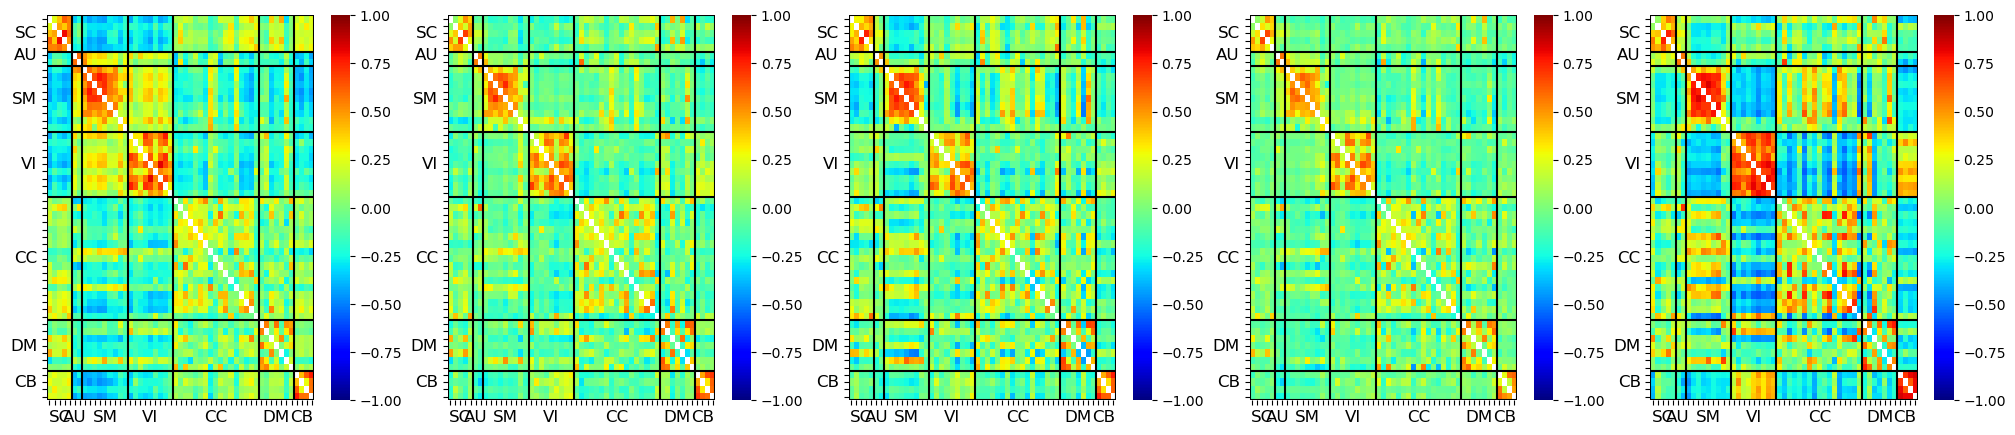

In [127]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
axs = axs.reshape(-1)

for i in range(0,5):
    vis_FNC(cluster_averages[i], axs[i], vmin=-1, vmax=1)

In [129]:
ad_dfnc_clstr = labels_l[:515].reshape((103, 5))
sz_dfnc_clstr = labels_l[515:].reshape((100, 5))

In [138]:
sz_dfnc_clstr.shape, ad_dfnc_clstr.shape

((100, 5), (103, 5))

In [140]:
ad_c1=[]
ad_c2=[]
ad_c3=[]
ad_c4=[]
ad_c5=[]
for i in range(ad_cnt):
    for j in range(5):
        if ad_dfnc_clstr[i,j] == 0:
            ad_c1.append(ad_dfnc[i,j,:,:])
        if ad_dfnc_clstr[i,j] == 1:
            ad_c2.append(ad_dfnc[i,j,:,:])
        if ad_dfnc_clstr[i,j] == 2:
            ad_c3.append(ad_dfnc[i,j,:,:])
        if ad_dfnc_clstr[i,j] == 3:
            ad_c4.append(ad_dfnc[i,j,:,:])
        if ad_dfnc_clstr[i,j] == 4:
            ad_c5.append(ad_dfnc[i,j,:,:])

In [142]:
sz_c1=[]
sz_c2=[]
sz_c3=[]
sz_c4=[]
sz_c5=[]
for i in range(sz_cnt):
    for j in range(5):
        if sz_dfnc_clstr[i,j] == 0:
            sz_c1.append(sz_dfnc[i,j,:,:])
        if sz_dfnc_clstr[i,j] == 1:
            sz_c2.append(sz_dfnc[i,j,:,:])
        if sz_dfnc_clstr[i,j] == 2:
            sz_c3.append(sz_dfnc[i,j,:,:])
        if sz_dfnc_clstr[i,j] == 3:
            sz_c4.append(sz_dfnc[i,j,:,:])
        if sz_dfnc_clstr[i,j] == 4:
            sz_c5.append(sz_dfnc[i,j,:,:])

In [145]:
adc= []
adc.append(len(ad_c1))
adc.append(len(ad_c2))
adc.append(len(ad_c3))
adc.append(len(ad_c4))
adc.append(len(ad_c5))

szc=[]
szc.append(len(sz_c1))
szc.append(len(sz_c2))
szc.append(len(sz_c3))
szc.append(len(sz_c4))
szc.append(len(sz_c5))

In [146]:
len(ad_c1)+len(ad_c2)+len(ad_c3)+len(ad_c4)+len(ad_c5)

515

In [147]:
len(sz_c1)+len(sz_c2)+len(sz_c3)+len(sz_c4)+len(sz_c5)

500

In [148]:

avg_ad_c = []
avg_ad_c.append(np.mean(ad_c1, axis=(0)))
avg_ad_c.append(np.mean(ad_c2, axis=(0)))
avg_ad_c.append(np.mean(ad_c3, axis=(0)))
avg_ad_c.append(np.mean(ad_c4, axis=(0)))
avg_ad_c.append(np.mean(ad_c5, axis=(0)))

                
avg_sz_c = []               
                
avg_sz_c.append(np.mean(sz_c1, axis=(0)))
avg_sz_c.append(np.mean(sz_c2, axis=(0)))
avg_sz_c.append(np.mean(sz_c3, axis=(0)))
avg_sz_c.append(np.mean(sz_c4, axis=(0)))
avg_sz_c.append(np.mean(sz_c5, axis=(0)))


In [149]:
ad_c1

[array([[        nan, -0.18017658,  0.00478332, ..., -0.23647156,
         -0.09158195, -0.14291828],
        [-0.18017658,         nan,  0.35839842, ..., -0.04449504,
         -0.33959434,  0.13995119],
        [ 0.00478332,  0.35839842,         nan, ...,  0.13391181,
          0.17875176,  0.37782202],
        ...,
        [-0.23647156, -0.04449504,  0.13391181, ...,         nan,
          0.60224129,  0.84601104],
        [-0.09158195, -0.33959434,  0.17875176, ...,  0.60224129,
                 nan,  0.6316517 ],
        [-0.14291828,  0.13995119,  0.37782202, ...,  0.84601104,
          0.6316517 ,         nan]]),
 array([[       nan, 0.26760255, 0.51220667, ..., 0.22821571, 0.06887858,
         0.15617895],
        [0.26760255,        nan, 0.78575711, ..., 0.74993208, 0.49571306,
         0.50187709],
        [0.51220667, 0.78575711,        nan, ..., 0.58688873, 0.26337294,
         0.20780411],
        ...,
        [0.22821571, 0.74993208, 0.58688873, ...,        nan, 0.79820162

Text(0.5, 0.98, 'Average dFNCs for AD and SZ clusters using lower triangles of dfncs')

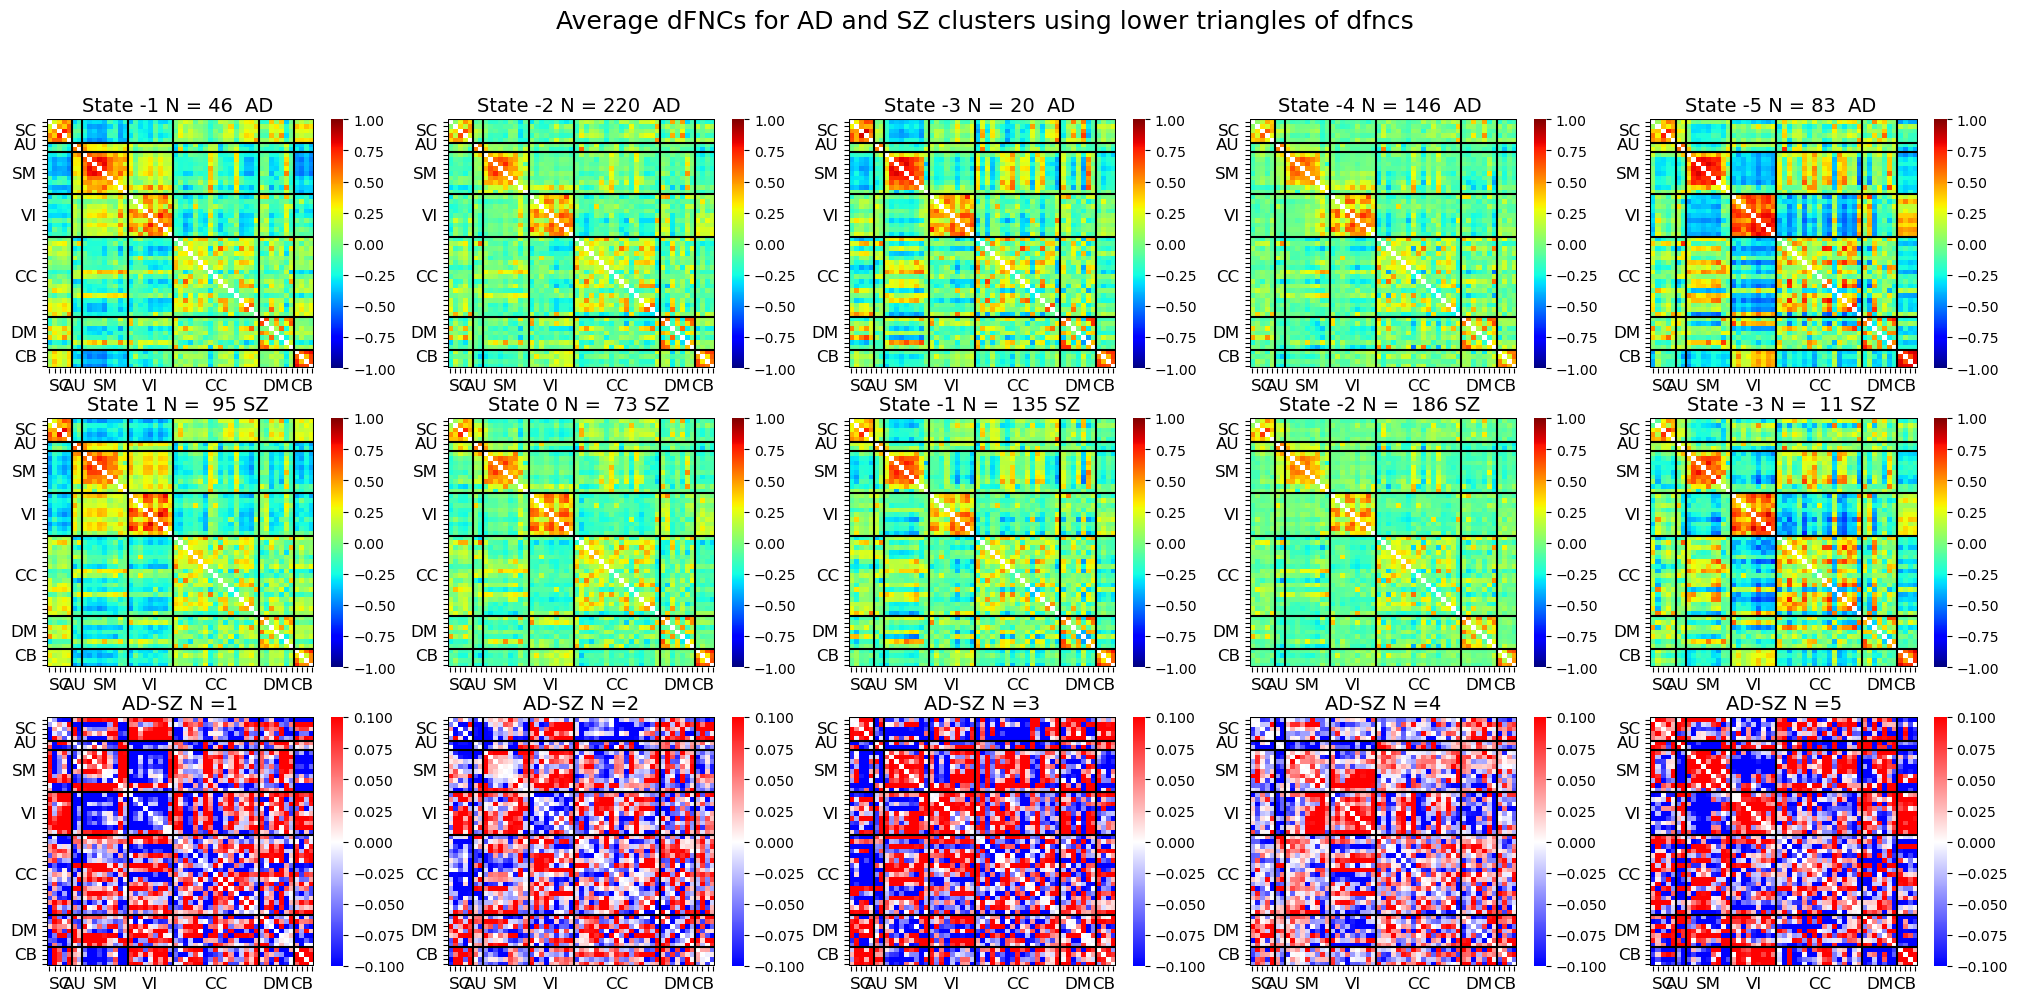

In [152]:
fig, axs = plt.subplots(3,5, figsize=(25,11))
axs = axs.reshape(-1)

for i in range(0,5):
    
    vis_FNC(avg_ad_c[i], axs[i], vmin=-1, vmax=1, ax_title=f"State -{i+1} N = {adc[i]}  AD ")
    vis_FNC(avg_sz_c[i], axs[i+5], vmin=-1, vmax=1, ax_title=f"State {-i+1} N =  {szc[i]} SZ ")
    
    diff = avg_ad_c[i] - avg_sz_c[i]
    vminmax = max(abs(diff.max().max()), abs(diff.min().min()))
    vis_FNC(avg_ad_c[i] - avg_sz_c[i], axs[i+10], vmin=-vminmax, vmax=vminmax, cmap="bwr",
            ax_title=f"AD-SZ N ={i+1}")
    
fig.suptitle('Average dFNCs for AD and SZ clusters using lower triangles of dfncs', fontsize=18)